# Features: tree canopy

In [ ]:
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
import tqdm
import xarray as xr
from rasterio import transform

from uhi_drivers_lausanne import canopy_utils, stac_utils

LIDAR_TREE_VALUES = [3]

figwidth, figheight = plt.rcParams["figure.figsize"]

(PDAL Error) Can't load library /home/martibosch/mambaforge/envs/uhi-drivers-lausanne/lib/libpdal_plugin_filter_trajectory.so: Failed to load "/home/martibosch/mambaforge/envs/uhi-drivers-lausanne/lib/libpdal_plugin_filter_trajectory.so": libglog.so.1: cannot open shared object file: No such file or directorypj_obj_create: Open of /home/martibosch/mambaforge/envs/uhi-drivers-lausanne/share/proj failed
pj_obj_create: Open of /home/martibosch/mambaforge/envs/uhi-drivers-lausanne/share/proj failed
pj_obj_create: Open of /home/martibosch/mambaforge/envs/uhi-drivers-lausanne/share/proj failed
pj_obj_create: Open of /home/martibosch/mambaforge/envs/uhi-drivers-lausanne/share/proj failed
(PDAL Error) Can't load library /home/martibosch/mambaforge/envs/uhi-drivers-lausanne/lib/libpdal_plugin_filter_trajectory.so: Failed to load "/home/martibosch/mambaforge/envs/uhi-drivers-lausanne/lib/libpdal_plugin_filter_trajectory.so": libglog.so.1: cannot open shared object file: No such file or directory

In [ ]:
stations_gdf_filepath = "../data/processed/stations.gpkg"
agglom_extent_filepath = "../data/raw/agglom-extent.gpkg"
surface3d_datetime = "2019/2019"
buffer_dists = [10, 30, 60, 90]
notree_value = 0

dst_canopy_res = 1
# given de point density of swissSURFACE3D, with a target resolution of 1 m,
# rasterization can lead to values up to ~250, so we need at least 8 bits to store the
# data array. However, we can only use unsigned types if we install the `netcdf4`
# package. Therefore, we use `int32` as the data type.
dst_dtype = "int32"
dst_filepath = "../data/interim/tree-canopy.nc"

In [ ]:
stations_gdf = gpd.read_file(stations_gdf_filepath)
# we set the index to the station name because otherwise we lose this information in the
# `buffer` operation below
station_id_col = stations_gdf.columns.drop("geometry")[0]
stations_gdf = stations_gdf.set_index(station_id_col)
# we use the agglomeration extent to filter out the Lake Leman from the buffers around
# the stations - we use iloc to get the Leman lake extent (the second item)
# we need to project the lake extent to the same CRS as the STAC swissSURFACE3D tiles
# (EPSG:4326) - note that this is different from the actual STAC
lake_extent_geom = (
    gpd.read_file(agglom_extent_filepath)
    .to_crs(stac_utils.CLIENT_CRS)["geometry"]
    .iloc[1]
)

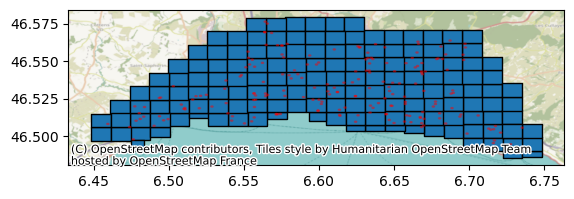

In [ ]:
# there is no need to project `stations_gdf` before applying `.buffer` since it is
# already EPSG:2056 (in meters) - but we need to project the buffered stations to the
# same CRS as the STAC swissSURFACE3D tiles.
# again, there is no need to project `stations_gdf` since it is already EPSG:2056, i.e.,
# the same as the swissSURFACE3D data
buffered_stations_gdf = gpd.GeoDataFrame(
    # geometry=stations_gdf.to_crs(SWISSSURFACE3D_CRS).buffer(buffer_dists[-1])
    geometry=stations_gdf.buffer(buffer_dists[-1]).to_crs(stac_utils.CLIENT_CRS)
)

# get the extent of our area of interest to query get the intersecting swissSURFACE3D
# tiles
extent_geom = buffered_stations_gdf.unary_union.convex_hull.difference(lake_extent_geom)

# get the swissSURFACE3D tile extents as a geo-data frame
client = stac_utils.SwissTopoClient()
surface3d_gdf = client.gdf_from_collection(
    stac_utils.SWISSSURFACE3D_COLLECTION,
    extent_geom=extent_geom,
    datetime=surface3d_datetime,
    extension=".zip",
)

# plot the swissSURFACE3D tiles and the buffered stations
ax = surface3d_gdf.plot(edgecolor="black")
buffered_stations_gdf.plot(ax=ax, color="red", alpha=0.5)
cx.add_basemap(ax, crs=buffered_stations_gdf.crs)

In [ ]:
# we want to minimize the download and opening of LiDAR files so we perform an overlay
# of the tile extent and buffered stations to get, for each tile, the list of stations
# whose largest buffer intersects
tile_stations_gdf = surface3d_gdf.overlay(
    buffered_stations_gdf.reset_index(), how="intersection"
)
# # we want to minimize the download and opening of LiDAR files so we perform a spatial
# # join of the tile extent and buffered stations to get, for each tile, the list of
# # stations whose largest buffer intersects
# tile_stations_gdf = surface3d_gdf.sjoin(
#     buffered_stations_gdf, how="inner", predicate="intersects"
# ).to_crs(SWISSSURFACE3D_CRS)

In [ ]:
# Note that the buffer around a station may intersect multiple tiles, so we may need to
# process several LiDAR files for each station. In order to download and open each LiDAR
# file only once, we create a data array to store the tree canopy array for each station
# which will be modified in place as we process each LiDAR file.
# minx, miny, maxx, maxy = buffered_station_gdf["geometry"].iloc[0].bounds
largest_buffer_pixels = int(buffer_dists[-1] / dst_canopy_res)
arr_side = 2 * largest_buffer_pixels
tree_canopy_da = xr.DataArray(
    np.full(
        (len(buffered_stations_gdf.index), arr_side, arr_side),
        notree_value,
        # dtype=np.uint8,
        dtype=dst_dtype,
    ),
    dims=(station_id_col, "i", "j"),
    coords={station_id_col: buffered_stations_gdf.index},
)
# we also create a dictionary to store the transform of each station's buffer array.
# Note that we do have to reproject the buffered stations to the same CRS as the
# swissSURFACE3D data (EPSG:2056, which is in meters) - again, not to be confused with
# the CRS of the STAC tiles (EPSG:4326).
transform_dict = {
    station_id: transform.from_bounds(*buffered_station_geom.bounds, arr_side, arr_side)
    for station_id, buffered_station_geom in buffered_stations_gdf["geometry"]
    .to_crs(stac_utils.SWISSSURFACE3D_CRS)
    .items()
}

In [ ]:
# for each swissSURFACE3D tile, we download the LiDAR data and extract the tree canopy
# for each of the stations that intersect the tile. Note again that we have to reproject
# the stations to the same CRS as the swissSURFACE3D data (EPSG:2056)
for url, gdf in tqdm.tqdm(
    tile_stations_gdf.to_crs(stac_utils.SWISSSURFACE3D_CRS).groupby(
        by=stac_utils.SWISSSURFACE3D_COLLECTION
    )
):
    arrays, transforms = canopy_utils.get_lidar_arrays(
        url,
        gdf["geometry"],
        LIDAR_TREE_VALUES,
        dst_canopy_res,
    )
    for (
        arr,
        t,
        station_index,
    ) in zip(arrays, transforms, gdf[station_id_col]):
        west, south, east, north = transform.array_bounds(*arr.shape, t)
        row_start, col_start = transform.rowcol(
            transform_dict[station_index], west, north
        )
        num_rows, num_cols = arr.shape
        # ACHTUNG: use the `+=` because tiles are not perfectly aligned with
        # `tree_canopy_da`, i.e., they are rhomboid-like, therefore we may write nodata
        # values (i.e., zeros) from the difference of the rhomboid and its containing
        # rectangle (i.e., the actual `arr.shape`), which may overlap an area of
        # `tree_canopy_da` that already had valid data from another tile. Taking
        # advantage of the fact that nodata is zero, using the `+=` will ensure that we
        # do not replace valid rasterized LiDAR values by zero and will not affect the
        # valid data either given the neutrality of zero w.r.t. the sum operation.
        tree_canopy_da.loc[
            station_index,
            row_start : row_start + num_rows,
            col_start : col_start + num_cols,
        ] += arr

100%|███████████████████████████████████████████████| 110/110 [54:55<00:00, 29.96s/it]


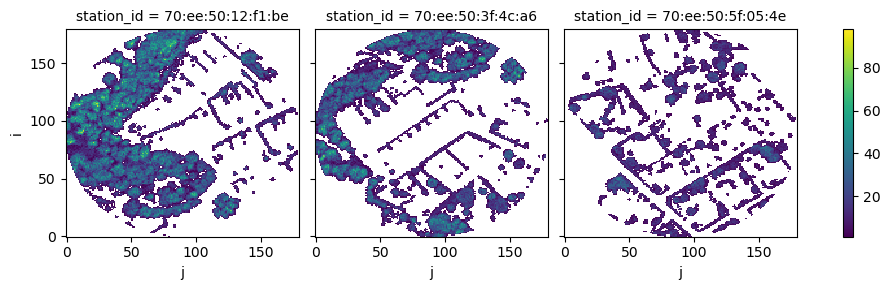

In [ ]:
num_sample_plots = 3
col_wrap = 3
sample_stations = (
    pd.Series(tree_canopy_da.coords[station_id_col]).sample(num_sample_plots).values
)
sample_da = tree_canopy_da.loc[sample_stations]
sample_da.where(sample_da != 0).plot(col=station_id_col, col_wrap=col_wrap)

## Dump the data array to file

At this point, we could compute the tree canopy cover features for each station but
we save the data array instead before reducing it to the features. This is because the
data array is computationally-expensive to obtain and we want to be able to re-use.

In [ ]:
# # we use the `netcdf4` engine to be able to save the data array as an unsigned integer
# # tree_canopy_da.to_netcdf(dst_filepath, format="NETCDF4", engine="netcdf4")
# make things simple and use int32 to avoid adding the `netcdf4` dependency
tree_canopy_da.to_netcdf(dst_filepath)